In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

In [3]:
def RMSLE(y_true, y_pred):
    """
    The Root Mean Squared Log Error (RMSLE) metric

    :param y_true: The ground truth labels given in the dataset
    :param y_pred: Our predictions

    :return: The RMSLE score
    """
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [6]:
train = pd.read_csv("train1.csv")
test = pd.read_csv("test1.csv")

test_ids = test["id"]

In [7]:
train.head()

,age,sex,bmi,children,smoker,region,charges,id
0,43,male,26.030,0,no,northeast,6837.36870,1
1,58,female,28.215,0,no,northwest,12224.35085,2
2,53,male,31.350,0,no,southeast,27346.04207,3
3,54,male,29.200,1,no,southwest,10436.09600,4
4,19,male,34.900,0,yes,southwest,34828.65400,5


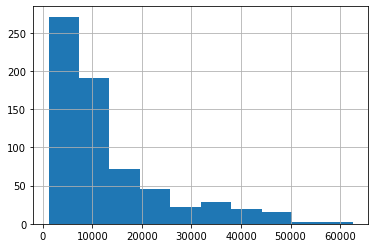

In [8]:
train["charges"].hist();

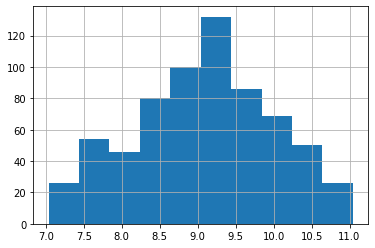

In [9]:
np.log1p(train["charges"]).hist();

In [10]:
# Целевая переменная

train_y = train["charges"]
train.drop(["charges"], axis=1, inplace=True)

In [11]:
train.drop(["id"], axis=1, inplace=True)
test.drop(["id"], axis=1, inplace=True)

In [12]:
# One-hot encoding для категориальных фичей

train = pd.concat(
    [
        train,
        pd.get_dummies(train[["sex", "region", "smoker"]], drop_first=True),
    ],
    axis=1,
).drop(["sex", "smoker", "region"], axis=1)

test = pd.concat(
    [
        test,
        pd.get_dummies(test[["sex", "region", "smoker"]], drop_first=True),
    ],
    axis=1,
).drop(["sex", "smoker", "region"], axis=1)

In [13]:
train.head()

,age,bmi,children,sex_male,region_northwest,region_southeast,region_southwest,smoker_yes
0,43,26.030,0,1,0,0,0,0
1,58,28.215,0,0,1,0,0,0
2,53,31.350,0,1,0,1,0,0
3,54,29.200,1,1,0,0,1,0
4,19,34.900,0,1,0,0,1,1


In [14]:
test.head()

,age,bmi,children,sex_male,region_northwest,region_southeast,region_southwest,smoker_yes
0,45,25.175,2,0,0,0,0,0
1,36,30.020,0,0,1,0,0,0
2,64,26.885,0,0,1,0,0,1
3,46,25.745,3,1,1,0,0,0
4,19,31.920,0,1,1,0,0,1


In [15]:
def cv_and_predict(
    df_train,
    df_test,
    train_y,
    model,
    log_transform_target=True,
    do_scaling=True,
    n_splits=5,
    random_state=42,
    verbose=True,
):
    """
    Функция для кросс-валидации и предикта на тест

    :param df_train: Трейн-датафрейм
    :param df_test: Тест-датафрейм
    :param train_y: Ответы на трейн
    :param model: Модель, которую мы хотим учить
    :param log_transform_target: Делаем ли лог-трансформацию таргета при обучении
    :param do_scaling: Делаем ли скейлинг признаков
    :param n_splits: Количество сплитов для KFold
    :param random_state: random_state для KFold
    :param verbose: Делаем ли print'ы

    :return: pred_test: Предсказания на тест; oof_df: OOF предсказания
    """

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # В датафрейме oof_df будут храниться настоящий таргет трейна и OOF предсказания на трейн.
    # Инициализируем prediction_oof нулями и будем заполнять предсказаниями в процессе валидации
    oof_df = pd.DataFrame()
    oof_df["target"] = train_y
    oof_df["prediction_oof"] = np.zeros(oof_df.shape[0])

    # Список с метриками по фолдам
    metrics = []

    # Предсказания на тест. Инициализируем нулями и будем заполнять предсказаниями в процессе валидации.
    # Наши предсказания будут усреднением n_splits моделей
    pred_test = np.zeros(df_test.shape[0])

    # Кросс-валидация
    for i, (train_index, valid_index) in enumerate(kf.split(df_train, train_y)):
        if verbose:
            print(f"fold_{i} started")

        X_train = df_train.loc[train_index]
        y_train = train_y.loc[train_index].values

        if log_transform_target:
            y_train = np.log1p(y_train)

        if do_scaling:
            scaler = StandardScaler()
            columns = X_train.columns
            X_train = scaler.fit_transform(X_train)
            X_train = pd.DataFrame(X_train)
            X_train.columns = columns

        X_valid = df_train.loc[valid_index]
        y_valid = train_y.loc[valid_index].values

        if do_scaling:
            X_valid = scaler.transform(X_valid)
            X_valid = pd.DataFrame(X_valid)
            X_valid.columns = columns

        model_kf = deepcopy(model)

        model_kf.fit(X_train, y_train)

        if do_scaling:
            df_test_scaled = scaler.transform(df_test)
            df_test_scaled = pd.DataFrame(df_test_scaled)
            df_test_scaled.columns = columns
            prediction_kf = model_kf.predict(df_test_scaled)
        else:
            prediction_kf = model_kf.predict(df_test)

        if log_transform_target:
            prediction_kf = np.expm1(prediction_kf)

        pred_test += prediction_kf / n_splits

        prediction = model_kf.predict(X_valid)

        if log_transform_target:
            prediction = np.expm1(prediction)
        oof_df.loc[valid_index, "prediction_oof"] = prediction

        cur_metric = RMSLE(y_valid, prediction)
        metrics.append(cur_metric)
        if verbose:
            print(f"metric_{i}: {cur_metric}")
            print()
            print("_" * 100)
            print()

    metric_OOF = RMSLE(train_y, oof_df["prediction_oof"])

    if verbose:
        print(f"metric_OOF: {metric_OOF}")
        print(f"metric_AVG: {np.mean(metrics)}")
        print(f"metric_std: {np.std(metrics)}")
        print()
        print("*" * 100)
        print()

    return pred_test, oof_df, metric_OOF

In [16]:
n_splits = 15

In [17]:
# Найдем оптимальный n_neighbors

metric_list = []
MAX_NEIGHBORS = 30
n_neighbors_list = list(range(1, MAX_NEIGHBORS))

for n_neighbors in tqdm(n_neighbors_list, desc="n_neighbors search"):
    model_knn = KNeighborsRegressor(
        n_neighbors=n_neighbors, n_jobs=4, weights="distance"
    )
    pred_test, oof_df, metric_OOF = cv_and_predict(
        train, test, train_y, model_knn, n_splits=n_splits, verbose=False
    )
    metric_list.append(metric_OOF)

min_metric, best_n_neighbors_idx = min(
    (val, idx) for (idx, val) in enumerate(metric_list)
)
best_n_neighbors = n_neighbors_list[best_n_neighbors_idx]

n_neighbors search:   0%|          | 0/29 [00:00<?, ?it/s]

In [18]:
best_n_neighbors

9

In [19]:
best_max_depth = 4

In [20]:
model_rf = RandomForestRegressor(
    n_estimators=1000, max_depth=best_max_depth, random_state=1337, n_jobs=4
)
model_knn = model_knn = KNeighborsRegressor(
    n_neighbors=best_n_neighbors, n_jobs=4, weights="distance"
)

In [21]:
%%time

pred_test_rf, oof_df_rf, metric_OOF_rf = cv_and_predict(train, test, train_y, model_rf, n_splits=n_splits, do_scaling=False)

fold_0 started
metric_0: 0.4194766254169486

____________________________________________________________________________________________________

fold_1 started
metric_1: 0.3502402018048199

____________________________________________________________________________________________________

fold_2 started
metric_2: 0.1878630017975103

____________________________________________________________________________________________________

fold_3 started
metric_3: 0.25683290212247

____________________________________________________________________________________________________

fold_4 started
metric_4: 0.5994549827857639

____________________________________________________________________________________________________

fold_5 started
metric_5: 0.5370406096276736

____________________________________________________________________________________________________

fold_6 started
metric_6: 0.4639432958875136

___________________________________________________________________________

In [22]:
%%time

pred_test_knn, oof_df_knn, metric_OOF_knn = cv_and_predict(train, test, train_y, model_knn, n_splits=n_splits, do_scaling=True)

fold_0 started
metric_0: 0.4361297361336031

____________________________________________________________________________________________________

fold_1 started
metric_1: 0.3808837219299926

____________________________________________________________________________________________________

fold_2 started
metric_2: 0.29892045766983694

____________________________________________________________________________________________________

fold_3 started
metric_3: 0.38358224922341194

____________________________________________________________________________________________________

fold_4 started
metric_4: 0.5945547294547506

____________________________________________________________________________________________________

fold_5 started
metric_5: 0.6047006387225101

____________________________________________________________________________________________________

fold_6 started
metric_6: 0.5091180355039084

_______________________________________________________________________

In [23]:
oof_df = oof_df_knn.copy()
oof_df.rename({"prediction_oof": "prediction_oof_knn"}, axis=1, inplace=True)
oof_df["prediction_oof_rf"] = oof_df_rf["prediction_oof"]

In [24]:
oof_df

,target,prediction_oof_knn,prediction_oof_rf
0,6837.36870,9140.937797,7413.368425
1,12224.35085,12015.993809,11994.798981
2,27346.04207,10567.988628,11780.408957
3,10436.09600,9434.992744,12149.136916
4,34828.65400,32950.627798,36287.876218
...,...,...,...
664,4561.18850,5559.888735,3835.561090
665,8582.30230,11507.027020,8177.382566
666,11931.12525,11827.886898,11976.935644
667,46113.51100,24765.798638,46110.153532


In [25]:
metric_list = []
alphas = np.linspace(0, 1, 101)
for alpha in alphas:
    oof_blend = np.expm1(
        np.array(
            np.log1p(oof_df["prediction_oof_knn"]) * alpha
            + np.log1p(oof_df["prediction_oof_rf"]) * (1 - alpha)
        )
    )
    metric_list.append(RMSLE(oof_df["target"], oof_blend))

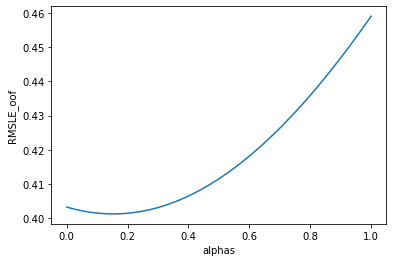

In [26]:
plt.plot(alphas, metric_list);
plt.xlabel("alphas");
plt.ylabel("RMSLE_oof");

In [27]:
min_metric, best_alpha_idx = min((val, idx) for (idx, val) in enumerate(metric_list))
best_alpha = alphas[best_alpha_idx]

In [28]:
best_alpha, min_metric

(0.15, 0.40120622038549625)

In [29]:
# Сравним OOF предсказания с константным бейзлайном и убедимся, что мы лучше

best_constant = np.expm1(np.mean(np.log1p(train_y)))
constant_baseline = np.ones(oof_df.shape[0]) * best_constant
RMSLE(constant_baseline, oof_df["target"])

0.9048047411379614

In [30]:
pred_test = np.expm1(
    np.array(
        np.log1p(pred_test_knn) * best_alpha + np.log1p(pred_test_rf) * (1 - best_alpha)
    )
)

In [31]:
submission = pd.DataFrame()
submission["id"] = test_ids
submission["charges"] = pred_test

In [32]:
submission.head()

,id,charges
0,770,8374.388386
1,771,5277.368733
2,772,26432.202697
3,773,8454.995403
4,774,33276.058150


In [34]:
submission.to_csv(f"sub_hardcore_n_splits_{n_splits}.csv", index=False)

<IPython.core.display.Javascript object>